# Introduction

This notebook creates two figures that show spatial and temporal prevelance of inferred drug resistance using the data from *Plasmodium falciparum* version 8 (Pf8) project. The first figure is a map of West African sampling locations with levels of inferred chloroquine resistance plotted as pie charts. The second figure is a line plot showing the prevalence of inferred chloroquine resistance in different countries over the years.


**This notebook should take approximately three minutes to run.**


# Setup

We will use a package called cartopy for making the maps in this notebook. It needs to be installed:

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 31.9 MB/s eta 0:00:00


We also need the malariagen data package to be installed:

In [ ]:
!pip install malariagen_data -q --no-warn-conflicts

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 5.6 MB/s eta 0:00:00

Import the required python libraries

In [ ]:
import pandas as pd
import numpy as np
import collections
import malariagen_data
import warnings
from google.colab import drive

#import plotting libraries
import matplotlib.pyplot as plt
import cartopy
import geopandas
import seaborn as sns

#specifc imports to map and plot samples
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from collections import Counter
from cartopy.io import shapereader, DownloadWarning
from time import strftime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from matplotlib.image import imread

Mount Google Drive to enable saving of the figure

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access Pf8 Data
We use the malariagen data package to load sample data and metadata

In [ ]:
sample_data = malariagen_data.Pf8()
sample_metadata = sample_data.sample_metadata()

For these figure, we also need to load the inferred drug resistance status classifications of of QC-pass Pf8 samples which we can access from the Sanger's cloud storage.

This dataset includes the samples that are predicted to be resistant to 10 drugs or combinations of drugs and to rapid diagnostic tests (RDT) detection: chloroquine, pyrimethamine, sulfadoxine, mefloquine, artemisinin, piperaquine, sulfadoxine- pyrimethamine for treatment of uncomplicated malaria, sulfadoxine- pyrimethamine for intermittent preventive treatment in pregnancy, artesunate-mefloquine, dihydroartemisinin-piperaquine, *hrp2* and *hrp3* gene deletions.

In [ ]:
# Read the file in as a pandas dataframe
res_class = pd.read_csv('https://pf8-release.cog.sanger.ac.uk/Pf8_inferred_resistance_status_classification.tsv', sep='\t').rename(columns={'sample':'Sample'})

In [ ]:
# Take a look at the structure of the drug resistance classification dataframe
res_class.head(3)

,Sample,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp),AS-MQ,DHA-PPQ
0,FP0008-C,Undetermined,Undetermined,Undetermined,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive
1,FP0009-C,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive
2,FP0010-CW,Undetermined,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive


You can see that this file contains a sample identifier, followed by information on the resistance of that sample to different antimalarial treatments.

### Inferred drug resistance in *P. falciparum*

For the Pf8 project samples were classified as resistant or sensitive to major antimalarials and combinations based on genotyping of known drug resistance alleles. The full list of alleles used for this analysis is found in Table 2 in another notebook. A full explanation of the methods for this classification process is detailed [here](https://pf8-release.cog.sanger.ac.uk/Pf8_resistance_classification.pdf).

The figures created by this notebook covers chloroquine resistance. Samples in Pf8 were classified according to their *crt* genotype at codon 76:
 - **K** = Sensitive
 - **T** = Resistant
 - **K/T** heterozygote = Undetermined
 - **missing** = Undetermined
 - **other mutation** = Undetermined

For more information on the drug chloroquine, you can [read here](https://en.wikipedia.org/wiki/Chloroquine)

# Combine data into a single dataframe
In order to create the final figure it is easier to have all relevant data combined.

For the final figure we need to keep:
- All samples from sample_metadata which pass QC (n = 24,409)
- Columns 2 to 9 from the res_class dataframe (these contain the drug resistance classifications)

In [ ]:
# Filter sample metadata to include only QC pass samples
sample_metadata_qcpass = sample_metadata[sample_metadata['QC pass'] == True]
sample_metadata_qcpass.shape

(24409, 17)

In [ ]:
# Trim res_class down to only relevant columns
res_class_trim = res_class.iloc[:, 0:9] # We keep the sample ID column to allow us to merge with sample_metadata using this information

In [ ]:
# Merge the two dataframes on identical Sample IDs
df_all_sample_metadata = pd.merge(
    left = sample_metadata_qcpass,
    right = res_class_trim,
    left_on = 'Sample',
    right_on = 'Sample',
    how = 'inner')

# View the new dataframe stucture
df_all_sample_metadata.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,...,Sample type,Sample was in Pf7,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp)
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,...,gDNA,True,Undetermined,Undetermined,Undetermined,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,...,gDNA,True,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,...,sWGA,True,Undetermined,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Resistant,Sensitive


## Plot 1: Chloroquine Resistance Map

### Figure plotting setup

Here we define a few items which will help us to plot the first figure.

In [ ]:
# Firstly, a list named 'drugs' which lists the antimalarial treatment types from our combined dataframe
# this leaves open the option of investigating other drugs should we be interested in doing that in the future.
drugs = [
    'Chloroquine',
    'Pyrimethamine',
    'Sulfadoxine',
    'Mefloquine',
    'Artemisinin',
    'Piperaquine',
    'SP (uncomplicated)',
    'SP (IPTp)',
]

In [ ]:
# Secondly, an ordered dictionary which maps the codes for major sub-populations to the full name of the major sub-population.
# We choose an ordered dictionary, rather than a regular python dictionary, to keep the order of our subpopulations from west to east.
populations = collections.OrderedDict()
populations['SA'] = 'South America'
populations['AF-W'] = 'West Africa'
populations['AF-C'] = 'Central Africa'
populations['AF-NE'] = 'Northeast Africa'
populations['AF-E'] = 'East Africa'
populations['AS-SA-W'] = 'Western South Asia'
populations['AS-SA-E'] = 'Eastern South Asia'
populations['AS-SEA-W'] = 'Western Southeast Asia'
populations['AS-SEA-E'] = 'Eastern Southeast Asia'
populations['OC-NG'] = 'Oceania'

In [ ]:
# Finally, an ordered dictionary which maps the codes for major sub-populations to a colour code.
# This ordered dictionary preserves the order of the subpopulations in the previous code block
population_colours = collections.OrderedDict()
population_colours['SA']       = "#4daf4a"
population_colours['AF-W']     = "#e31a1c"
population_colours['AF-C']     = "#fd8d3c"
population_colours['AF-NE']    = "#bb8129"
population_colours['AF-E']     = "#fecc5c"
population_colours['AS-SA-W']  = "#dfc0eb"
population_colours['AS-SA-E']  = "#984ea3"
population_colours['AS-SEA-W'] = "#9ecae1"
population_colours['AS-SEA-E'] = "#3182bd"
population_colours['OC-NG']    = "#f781bf"


### Create data summaries
These will be used to build the final figure.

#### 1. Aggregation functions
Here we define two functions **proportion_agg** and **n_agg**.

Proportion_agg summarises the proportion of samples listed as 'Resistant' out of all samples which are listed as either 'Sensitive' or 'Resistant' - i.e. not 'Undetermined'. It returns a pandas series object with this information.

n_agg does the same but for the counts, rather than proportions.

In [ ]:
def proportion_agg(x):
    names = collections.OrderedDict() # create an empty ordered dictionary
    for drug in drugs: # Loop over each drug type
        n = np.count_nonzero( (x[drug] != 'Undetermined') ) # Count how many entries are not 'Undetermined'
        if n == 0:
            proportion = np.nan # Assign nan if none
        else:
            proportion = np.count_nonzero( # Otherwise, calculate the proportion of samples which are 'Resistant'
                ( x[drug] == 'Resistant')
            ) / np.count_nonzero(
                ( x[drug] != 'Undetermined' )
            )

        names[drug] = proportion
    return pd.Series(names)

def n_agg(x):
    names = collections.OrderedDict()
    for drug in drugs:
        n = np.count_nonzero( (x[drug] != 'Undetermined') )
        names[drug] = n
    return pd.Series(names)


#### 2. Data filtering and summaries

Here we create further data subsets and summaries to help with plotting the final figure.

**Note**: The defined values can be adjusted. However, modifying the location (which can be a list of countries, populations, or Admin Level 1) may require further adjustments, such as updating the map.

In [ ]:
# Define some limits on which samples are going to be included
min_year=2018
max_year=2022
location= ['AF-W']
drug='Chloroquine'
min_n = 25 # This is the minimum number of samples needed with an unambiguous inferred drug resistance phenotype

In [ ]:
# Create a new dataframe which includes only samples which meet the year range specified previously
df = df_all_sample_metadata.loc[
        df_all_sample_metadata['QC pass'] # Also only include samples passing QC
        & ( df_all_sample_metadata['Year'].astype(int) >= min_year )
        & ( df_all_sample_metadata['Year'].astype(int) <= max_year )
    ]

df = df.copy() # Avoids SettingWithCopyWarning
df.loc[:, 'Year group'] = f"{min_year}-{max_year}" # Create a new column for year group in the new dataframe

# Filter the dataframe by location criteria specified above
for i, loc in enumerate(location):
    if i == 0:
        df = df.loc[df['Population'] == loc]
    if i == 1:
        df = df.loc[df['Country'] == loc]
    if i == 2:
        df = df.loc[df['Admin level 1'] == loc]

In [ ]:
# Create a dataframe for the sample frequencies of this new filtered dataframe 'df' using the function 'proportion_agg'
df_freqs = (
    pd.DataFrame(
        df
        .groupby(['Admin level 1 longitude', 'Country', 'Admin level 1', 'Year group'])
        .apply(proportion_agg, include_groups=False)[drug]
    ).reset_index()
)

# Create a dataframe for the sample counts of this new filtered dataframe 'df' using the function 'n_agg'
df_n = (
    pd.DataFrame(
        df
        .groupby(['Admin level 1 longitude', 'Country', 'Admin level 1', 'Year group'])
        .apply(n_agg, include_groups=False)[drug]
    ).reset_index()
)

# Create a new column for Location which includes info on the location but also the sample counts per location
df_freqs['Location'] = df_n.apply(lambda row: f"{row['Admin level 1']}, {row['Country']} ($n$={row['Chloroquine']})", axis=1)

# Filter the 'Location' and resistance proportion data based on a condition where the count of 'Chloroquine' is at least the previously specified minimum count (25).
locations = df_freqs['Location'][df_n['Chloroquine'] >= min_n]
resistance_proportions = df_freqs['Chloroquine'][df_n['Chloroquine'] >= min_n]



View the West African locations for which we have at least 25 samples with an unambiguous chloroquine resistance classification.

In [ ]:
locations

,Location
0,"Western, Gambia ($n$=122)"
1,"Upper River, Gambia ($n$=156)"
2,"Koulikoro, Mali ($n$=50)"
3,"Segou, Mali ($n$=32)"
4,"Ashanti, Ghana ($n$=114)"
5,"Central, Ghana ($n$=203)"
6,"Upper East, Ghana ($n$=1521)"
7,"Eastern, Ghana ($n$=72)"
8,"Greater Accra, Ghana ($n$=385)"
9,"Ogun, Nigeria ($n$=38)"


## Plot the figure

### Load map images

In [ ]:
# First we need to download the map image file via a web link:
!wget https://naturalearth.s3.amazonaws.com/4.1.1/50m_raster/NE1_50M_SR_W.zip

--2025-02-26 23:03:47--  https://naturalearth.s3.amazonaws.com/4.1.1/50m_raster/NE1_50M_SR_W.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.218.153.43, 52.218.229.219, 52.218.250.203, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.218.153.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88413091 (84M) [application/zip]
Saving to: ‘NE1_50M_SR_W.zip’

NE1_50M_SR_W.zip    100%[===================>]  84.32M  62.7MB/s    in 1.3s    

2025-02-26 23:03:48 (62.7 MB/s) - ‘NE1_50M_SR_W.zip’ saved [88413091/88413091]



In [ ]:
# Unzip the file and define the path to the image file:
!unzip './NE1_50M_SR_W.zip'
image = './NE1_50M_SR_W/NE1_50M_SR_W.tif'

Archive:  ./NE1_50M_SR_W.zip
replace NE1_50M_SR_W/NE1_50M_SR_W.tfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NE1_50M_SR_W/NE1_50M_SR_W.tfw  
replace NE1_50M_SR_W/NE1_50M_SR_W.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NE1_50M_SR_W/NE1_50M_SR_W.tif  
replace NE1_50M_SR_W/Read_me.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NE1_50M_SR_W/Read_me.txt  


### The main plot commands

In [ ]:
# Set the figure resolution - higher values = higher resolution
plt.rcParams['figure.dpi'] = 200
fig = plt.figure()

<Figure size 1280x960 with 0 Axes>

In [ ]:
# Create a list of dictionaries 'location_coords'
# This list stores information for each location in the plot:
# annotation_ha sets the alignment of the pie chart with a location
# x/y_offsets set how far off the centre alignment the pie chart will appear
# pie_lon, pie_lat set the coordinates of each pie chart
# connection_style sets the connector line

# Note that here the administrative divisions are hard coded - i.e. written out rather than linked to a variable
# If you were to investigate a different region, you may need to re-write these names according to
# what is contiained within the 'locations' variable, as well as tweaking the other values
# to suit your new map

locations_coords = [
        dict(location = ('Western'), annotation_ha='center' ,       x_offset=-2 , y_offset=-1.5, pie_lon=-1, pie_lat=0, connection_style ="arc3,rad=0."),
        dict(location = ('Upper River'), annotation_ha='center',    x_offset=0.2 , y_offset=-0.7, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Koulikoro'), annotation_ha='center' ,     x_offset=2.5 , y_offset=0.8, pie_lon=0.7071, pie_lat=0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Segou'), annotation_ha='center' ,        x_offset=-1.5 , y_offset=-2, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Ashanti'), annotation_ha='center' ,       x_offset=-2.2 , y_offset=1, pie_lon=-0.7071, pie_lat=0.7071, connection_style ="arc3,rad=0."),
        dict(location = ('Central'),annotation_ha='center' ,        x_offset=-2 , y_offset=-2, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=0."),
        dict(location = ('Upper East'), annotation_ha='center' ,    x_offset=0 , y_offset=2.5, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Eastern'), annotation_ha='center' , x_offset=0 , y_offset=-2.8, pie_lon=0, pie_lat=-1, connection_style ="arc3,rad=0."),
        dict(location = ('Greater Accra'), annotation_ha='center' , x_offset=2 , y_offset=-2.5, pie_lon=0, pie_lat=-1, connection_style ="arc3,rad=0."),
        dict(location = ('Ogun'),annotation_ha='center' ,          x_offset=0 , y_offset=-1.3, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Oyo'), annotation_ha='center' ,    x_offset=2 , y_offset=2, pie_lon=0.7071, pie_lat=0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Ondo'), annotation_ha='center' ,      x_offset=2 , y_offset=-2, pie_lon=0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Adamawa'), annotation_ha='center' ,      x_offset= -0.3 , y_offset=-2, pie_lon=0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),

]

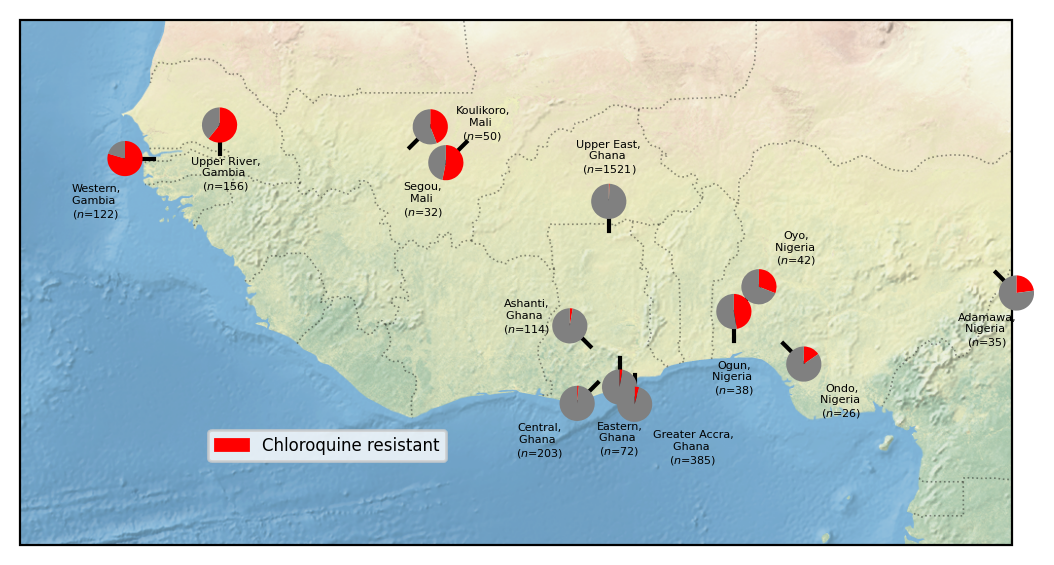

In [ ]:
# The final function for plotting

# Set up the plot axes using a Plate Carrée projection
# A Plate Carrée projection sets lines of latitude and longitude
# to be represented as equally spaced horizontal and vertical lines
# Suppress warnings from 'imread' that let us know the image file is downloaded from a URL
# Next line after this will download an additional map for drawing borders
warnings.filterwarnings("ignore", category=UserWarning)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(imread(image), origin='upper', transform= ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])

# Next line after this will download an additional map for drawing borders
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DownloadWarning)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6, alpha=0.4) # This adds border lines between countries

# Make a new dataframe 'proportion_resistant' which sets a new index and drops the old index
proportion_resistant = resistance_proportions.reset_index(drop = True)

# Iterate over locations
for n, loc in enumerate(locations):
    adm1 = loc.split(',')[0] # Save the part of the 'loc' string occuring before the comma ',' as adm1

    # Extract latitude and longitude for the location
    lat = np.unique(df_all_sample_metadata.loc[df_all_sample_metadata['Admin level 1'] == adm1]['Admin level 1 latitude'])
    lon = np.unique(df_all_sample_metadata.loc[df_all_sample_metadata['Admin level 1'] == adm1]['Admin level 1 longitude'])

    # Define the function 'plot_pie' to make a pie chart per location
    # This function takes parameters including the proportion of resistant samples,
    # The location coordinates (lon, lat)
    # ax = location on larger map of West Africa
    # width, height = size of pie chart
    def plot_pie(proportion_resistant,lon,lat,ax,width,height):
        ax_sub = inset_axes(
            ax, width, height, loc=10,
            bbox_to_anchor=(lon + locations_coords[n]['pie_lon'], lat + locations_coords[n]['pie_lat']),
            bbox_transform=ax.transData,
            borderpad=0
        )
        # Set colours for the pie chart
        wedges,texts= ax_sub.pie(proportion_resistant, colors = ['red', 'grey'], radius=2.75, startangle=90, counterclock=False)

        # Set the line connector between pie chart and location
        ax.plot(
            [lon, lon + locations_coords[n]['pie_lon']]
            , [lat, lat + locations_coords[n]['pie_lat']]
            , color='black'
        )
        # Set annotations for the pie chart
        ax.annotate(loc.split(', ')[0] + ',\n' + loc.split(', ')[1].split('(')[0] + '\n(' + loc.split('(')[1],
                    xy=(lon, lat),
                    xycoords='data',
                    xytext=(
                        lon + locations_coords[n]['x_offset'],
                        lat + locations_coords[n]['y_offset']
                    ),
                    textcoords='data',
                    fontsize=4,
                    ha = locations_coords['location' == adm1]['annotation_ha'],
                    va = 'center'
                    )
    plot_pie([proportion_resistant[n],1-proportion_resistant[n]],lon,lat,ax,.08,.08)

# Set final plot axes limits
ax.set_xlim(-21, 13)
ax.set_ylim(0, 18)

# Set a legend
red_patch = mpatches.Patch(color='red', label='Chloroquine resistant')
plt.legend(handles=[red_patch],loc=(-50,-10),prop={'size': 6})

# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'map_waf_chloroquine'

# We save as both .png and .PDF files
plt.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
plt.savefig(f'{file_path}{file_name}.pdf')

plt.show()

**Figure legend**: Heterogeneity of chloroquine resistance in West Africa. Inferred resistance levels to chloroquine between 2018 and 2022 in different administrative divisions within West Africa. We only include locations for which we have at least 25 samples with an unambiguous inferred chloroquine resistance phenotype. Note the very different chloroquine resistance profiles in different countries, e.g. Ghana and Mali.

## Figure 2: Line plot of Inferred Drug Resistance Over Time

To visualize temporal trends in drug resistance prevalence, we will use line plots to illustrate changes in resistance over time. To enhance applicability to other drugs and conditions, we will write a function that enables easy selection of:

*   Countries
*   Drug
*   Years

Unlike the previous map, samples will be grouped by year and country rather than by administrative division. After filtering, the function will calculate the prevalence of resistance along with the standard error to quantify uncertainty in the estimates.


In [ ]:
def filter_samples_calculate_prevalence(df_all_sample_metadata, country=None, min_year=None, max_year=None, population=None, drug='Chloroquine', min_n=None, based= 'Year'):
    """
    Filter samples based on year, location, drug resistance phenotype, and country.

    Parameters:
    - df_all_sample_metadata (DataFrame): DataFrame with sample metadata
    - country (list of str, optional): List of countries to filter on. Default is None, which doesn't filter by country.
    - min_year (int, optional): Minimum year for inclusion. Default value is None, which means no subset.
    - max_year (int, optional): Maximum year for inclusion. Default is None, which means no subset.
    - location (list of str, optional): List of locations for filtering. Default is None.
    - drug (str, optional): Drug, see above for the full list. Default is 'Chloroquine'.
    - min_n (int, optional): Minimum sample count needed for each country-year pair. Default is 25.

    Returns:
    - DataFrame with filtered sample frequencies and counts.
    """

    # Filter by year range and QC pass
    if min_year and max_year:

      df = df_all_sample_metadata.loc[
          (df_all_sample_metadata['Year'].astype(int) >= min_year) &
          (df_all_sample_metadata['Year'].astype(int) <= max_year)
      ]
      df['Year group'] = f"{min_year}-{max_year}"
    else:
      df= df_all_sample_metadata

    # Copy dataframe to avoid SettingWithCopyWarning and add year group column
    df = df.copy()


    if population:
        df = df.loc[df['Population'].isin(population)]

    # Filter by country if provided
    if country:
        df = df.loc[df['Country'].isin(country)]


    if min_n:
      # Calculate sample counts using n_agg function
      df_n = (
          pd.DataFrame(
              df.groupby(['Country', 'Year'])
              .apply(n_agg, include_groups=False)[drug]
          ).reset_index()
      )

      # Filter (Country, Year) groups that do not meet min_n
      valid_groups = df_n[df_n[drug] >= min_n][['Country', 'Year']]

      # Merge valid groups back to the main dataframe to filter `df`
      df = df.merge(valid_groups, on=['Country', 'Year'], how='inner')

        # Calculate frequencies of the specified drug using proportion_agg function
    df_freqs = (
        pd.DataFrame(
            df.groupby(['Country', 'Year'])
            .apply(proportion_agg, include_groups=False)[drug]
        ).reset_index()
    )
    df_freqs['Resistant Proportion'] = df_freqs[drug] * 100

    if min_n:
      df_freqs = df_freqs.merge(df_n, on=['Country', 'Year'], how='left', suffixes=('', '_count'))

    # Calculate binomial standard error
    df_freqs['Standard Error'] = np.sqrt(
        (df_freqs['Resistant Proportion'] / 100) * (1 - df_freqs['Resistant Proportion'] / 100) / df_freqs[f"{drug}_count"]
    ) * 100

    return df_freqs


Now let's test the function!

In [ ]:
df_filtered = filter_samples_calculate_prevalence(
    df_all_sample_metadata,
    country=["Ghana", "Gambia", "Kenya", "Democratic Republic of the Congo",  "Tanzania"],  # List of countries to filter
    drug='Chloroquine',
    min_n=25
)

df_filtered.head()

,Country,Year,Chloroquine,Resistant Proportion,Chloroquine_count,Standard Error
0,Democratic Republic of the Congo,2012.0,0.680851,68.085106,141,3.925665
1,Democratic Republic of the Congo,2013.0,0.741573,74.157303,89,4.640351
2,Democratic Republic of the Congo,2014.0,0.522727,52.272727,88,5.324509
3,Democratic Republic of the Congo,2015.0,0.515152,51.515152,33,8.699886
4,Democratic Republic of the Congo,2016.0,0.524590,52.459016,61,6.394097


We will loop over the countries and plot data points for each on the same panel. Data points will be connected with solid lines if consecutive years have data, and dashed lines if there are gaps between years. Finally, we will plot error bars to represent the standard error of resistance estimates.

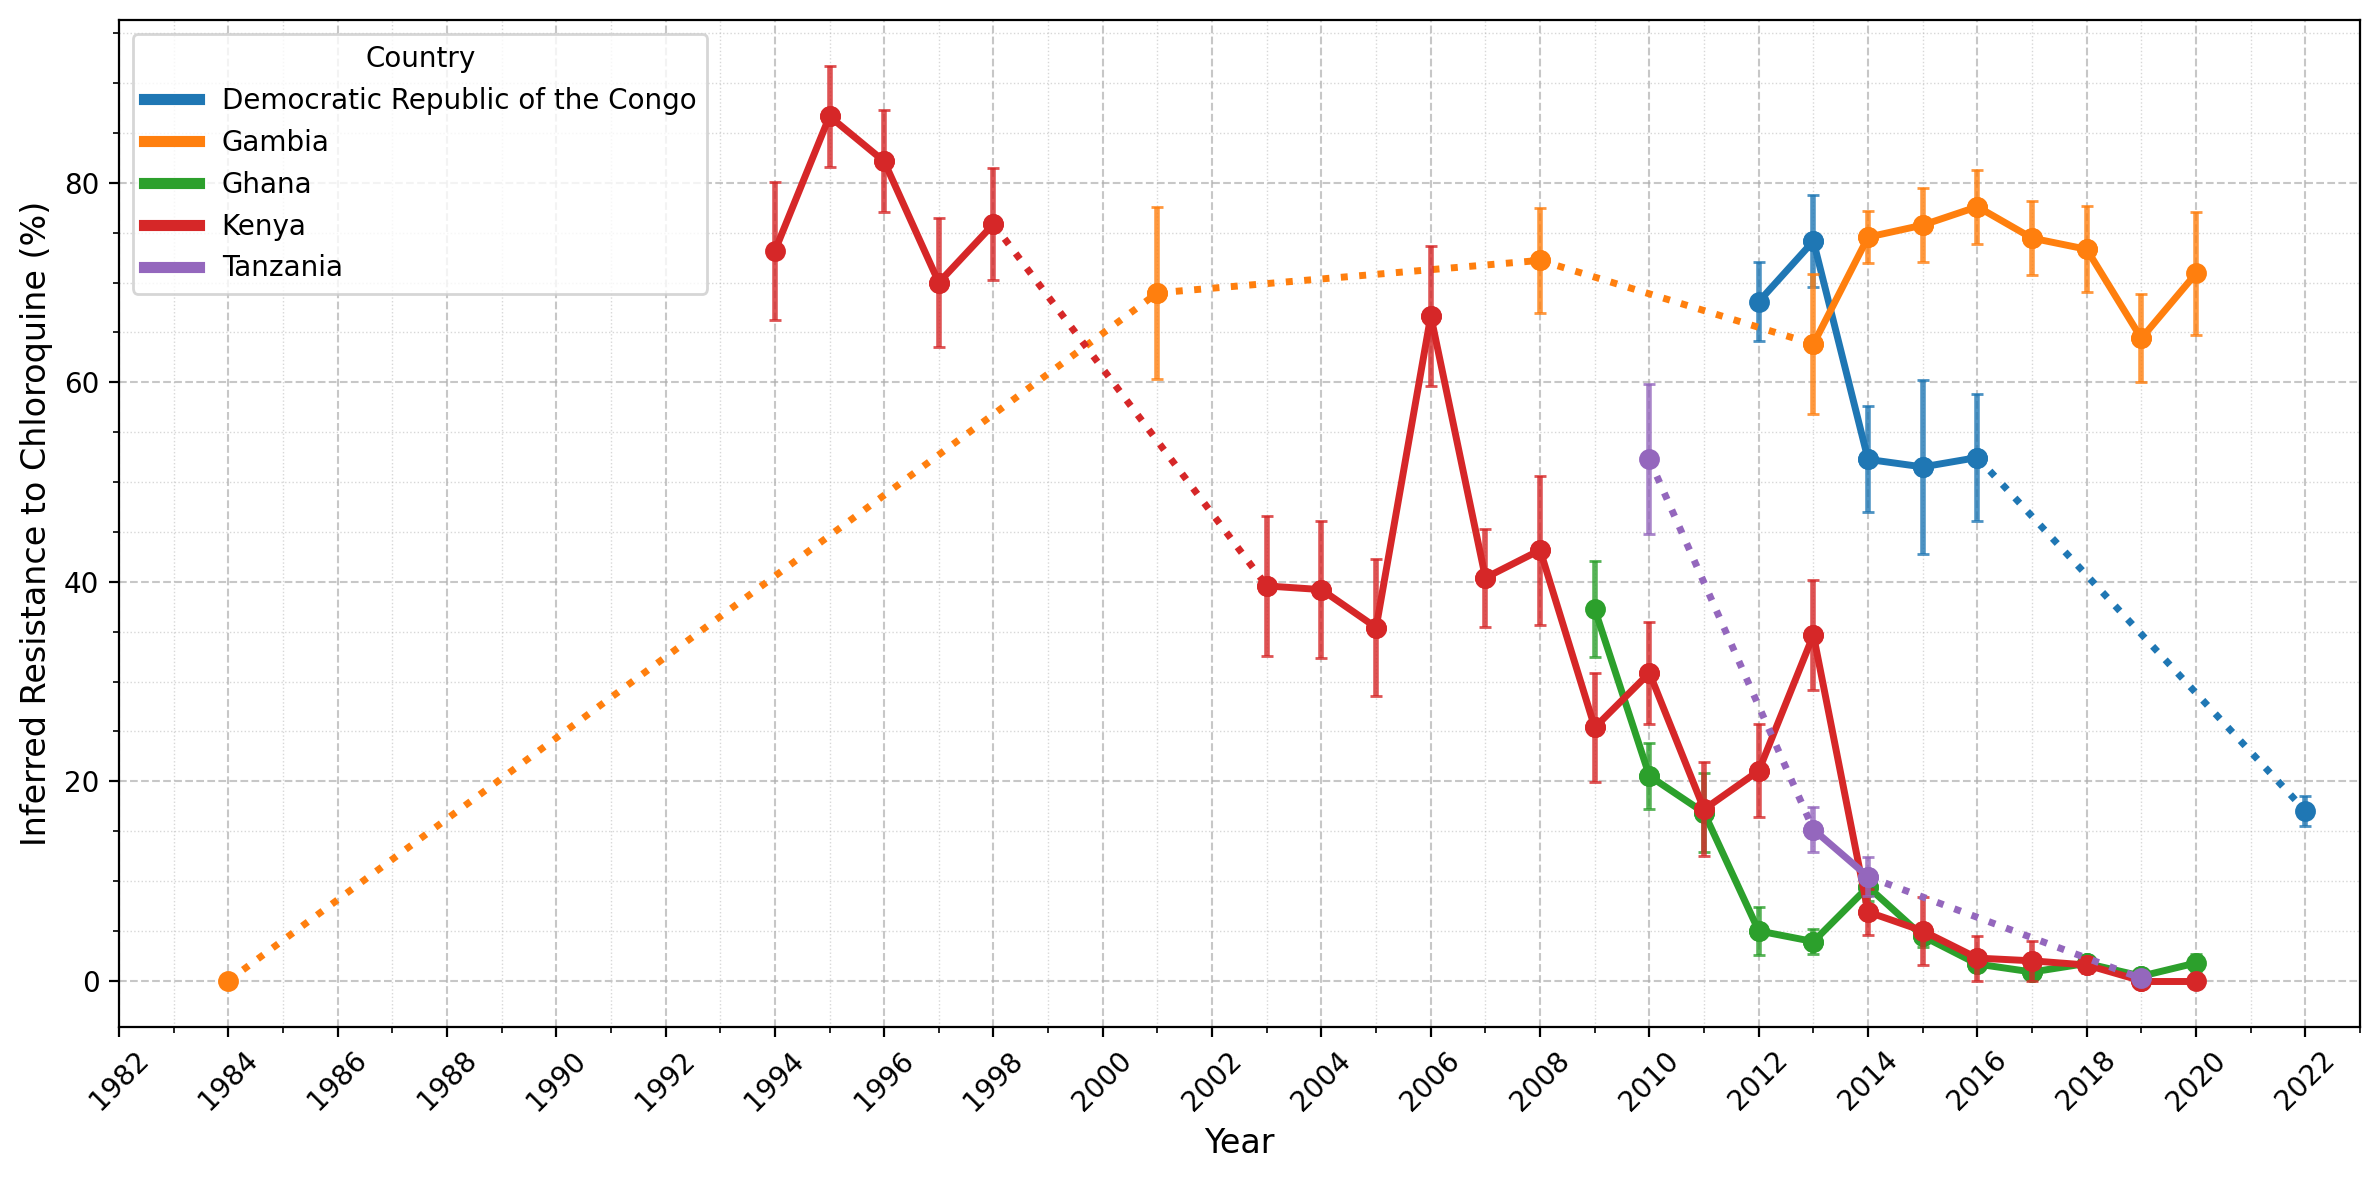

In [ ]:
# Define x-axis limits and tick intervals
x_min, x_max = 1982, 2023
x_ticks = range(x_min, x_max + 1, 2)

plt.figure(figsize=(12, 6))  # Set figure size

# Loop through each country to plot its resistance trend
for country in df_filtered["Country"].unique():
    # Extract data for the current country
    country_data = df_filtered[df_filtered["Country"] == country]

    # Assign a unique color to the country from Seaborn's "tab10" palette
    country_color = sns.color_palette("tab10")[list(df_filtered["Country"].unique()).index(country)]

    # Sort data by Year to ensure proper time series plotting
    country_data = country_data.sort_values("Year")
    years = country_data["Year"].values
    resistances = country_data["Resistant Proportion"].values

    # Determine the line style: solid for consecutive years, dashed if there's a gap
    line_styles = []
    for i in range(len(years) - 1):
        if years[i + 1] - years[i] > 1:  # If there is a gap of more than 1 year
            line_styles.append(":")  # Dashed line
        else:
            line_styles.append("-")  # Solid line

    # Plot data points and connect them with appropriate line styles
    for i in range(len(years) - 1):
        plt.plot(
            [years[i], years[i + 1]],  # X-axis values (Years)
            [resistances[i], resistances[i + 1]],  # Y-axis values (Resistance proportion)
            linestyle=line_styles[i],  # Apply solid or dashed line
            color=country_color,  # Use country-specific color
            linewidth=2.5,  # Set line width
            marker="o",  # Use circles for data points
            markersize=6.5  # Size of data point markers
        )

    # Add error bars representing the standard error of resistance estimates
    plt.errorbar(
        country_data["Year"],  # X-axis: Years
        country_data["Resistant Proportion"],  # Y-axis: Resistance proportion
        yerr=country_data["Standard Error"],  # Error bar values
        fmt="none",  # Do not plot additional markers
        ecolor=country_color,  # Match error bar color to country color
        elinewidth=2,  # Error bar line width
        capsize=2,  # Small horizontal caps at the ends of error bars
        alpha=0.8  # Transparency for better visibility
    )

# Set axis labels
plt.xlabel("Year", fontsize=12)
plt.ylabel("Inferred Resistance to Chloroquine (%)", fontsize=12)

# Configure x-axis ticks
plt.xticks(x_ticks, rotation=45)  # Rotate x-axis labels for better readability
plt.xlim(x_min, x_max)  # Set x-axis limits

# Add gridlines for better readability
plt.grid(which="major", linestyle="--", linewidth=0.75, alpha=0.7)  # Major gridlines (dashed)
plt.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.5)  # Minor gridlines (dotted)
plt.minorticks_on()  # Enable minor ticks
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))  # Minor ticks for every year

# Create a legend mapping colors to country names
handles = [
    plt.Line2D([0], [0], color=sns.color_palette("tab10")[i], lw=4, label=country)
    for i, country in enumerate(df_filtered["Country"].unique())
]
plt.legend(handles=handles, title="Country", loc='upper left', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing

# Save the figure as a high-resolution PNG file
plt.show()  # Display the plot
plt.savefig("line_resistance_trends_country_year.png", dpi=500, bbox_inches='tight')



**Figure Legend**: Inferred frequency of chloroquine resistance in five African countries.  Points represent years for which more than 25 samples were available for a given country, while error bars show the standard error for a given year. Solid lines connect consecutive time points, while dotted lines indicate gaps greater than one year between adjacent time points, where years in between each had fewer than 25 samples. Notably, resistance has declined in Ghana, Kenya, and Tanzania from 20-60% to less than 5% since 2010. In the Democratic Republic of the Congo, resistance remained high until 2016 before decreasing, though there was only a single observation available after 2016. In contrast, Gambia is an outlier; after a sharp increase between 1984-2001, resistance has remained stable (60-80%) since around 2001.